In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/books-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/books-dataset


In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai


In [26]:
for file in os.listdir(path):
    print(file)

df = pd.read_csv(path + "/data.csv" )
df.head()

intents.json
data.csv


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [31]:
df[df['authors'].isna()]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
646,9780140059021,0140059024,Wodehouse on crime,NaN,NaN,NaN,http://books.google.com/books/content?id=YrZrA...,NaN,1981.0,4.39,557.0,3143.0
854,9780140509786,014050978X,"Burt Dow, Deep-Water Man",NaN,NaN,Juvenile Fiction,http://books.google.com/books/content?id=fwlV2...,"Burt goes fishing, takes refuge from a storm i...",1989.0,4.10,64.0,645.0
885,9780141026282,0141026286,The Epic of Gilgamesh,NaN,NaN,Fiction,http://books.google.com/books/content?id=GJ-gP...,Enkidu is created by the gods to challenge the...,2006.0,3.67,120.0,51735.0
890,9780141181226,0141181222,One Flew Over the Cuckoo's Nest,NaN,NaN,Fiction,http://books.google.com/books/content?id=j6NsK...,"McMurphy, a criminal who feigns insanity, is a...",1962.0,4.19,281.0,3859.0
985,9780142300701,0142300705,A Year Down Yonder,NaN,NaN,Juvenile Fiction,http://books.google.com/books/content?id=D_Vju...,"During the recession of 1937, fifteen-year-old...",2002.0,4.11,160.0,25534.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6383,9781593075422,1593075421,Museum of Terror,NaN,NaN,Comics & Graphic Novels,http://books.google.com/books/content?id=9XRQA...,Dark Horse Comics is very proud to present Mus...,2006.0,4.09,375.0,1399.0
6645,9781883011499,1883011493,Crime Novels,American Noir of the 1930s and 40s,NaN,American fiction,NaN,A collection of classic stories exemplify the ...,1997.0,4.36,892.0,414.0
6674,9781891830600,1891830600,Carnet de Voyage,NaN,NaN,Comics & Graphic Novels,http://books.google.com/books/content?id=UUxUR...,Craig Thompson - the award-winning creator of ...,2004.0,3.76,224.0,4294.0
6745,9781932416060,1932416064,McSweeney's,Twelve new stories from twelve new writers--un...,NaN,American literature,NaN,NaN,2003.0,3.85,273.0,189.0


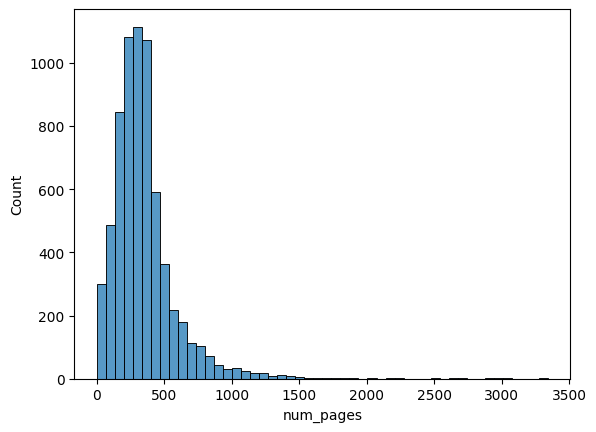

In [39]:
# print the num_pages and ratings_count on bar charts

plt.figure()
sns.histplot(x=df['num_pages'], bins=50)
plt.show()

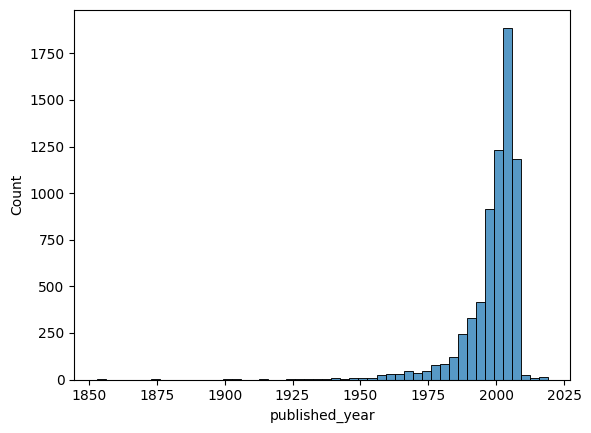

In [46]:
plt.figure()
sns.histplot(x=df['published_year'], bins=50)
plt.show()